# EKF

ekf是扩展卡尔曼滤波的缩写：Extended Kalman Filter

本文将从概率论中的相关概念说起，逐步讲解到贝叶斯滤波、卡尔曼滤波、和扩展卡尔曼滤波。重点将放在两个例子上：ekf定位和ekf slam的python程序。


## 1 卡尔曼滤波

### 概率论基础

关于随机变量、概率密度函数、正态分布、贝叶斯法则等建议首先了解基本概念。

随机变量的**期望**：
 
$$\mathbb E[X] = \sum_{i=1}^n p_ix_i$$

连续形式：

$$\mathbb E[X] = \int_{-\infty}^\infty x\, f(x) \,dx$$


In [1]:
import numpy as np
import random
x=[3,1,2]
p=[0.1,0.3,0.4]
E_x=np.sum(np.multiply(x,p))
print(E_x)

1.4


随机变量的期望可以看做代表了随机变量的平均值，而随机变量的**方差**描述了随机变量围绕平均值的分散情况：

$$\mathit{VAR}(X) = \frac{1}{n}\sum_{i=1}^n (x_i - \mu)^2$$

In [2]:
x=np.random.randn(10)
np.var(x)

0.94945573315067155

多元分布指的是具有多个变量的随机分布。例如二维空间中的机器人位置需要用x和y两个变量描述，为了描述它们，需要用在x和y上都有均值的二元正态分布。

对于多元分布来说，均值 $\mu$ 可以用向量来表示：


$$
\mu = \begin{bmatrix}\mu_1\\\mu_2\\ \vdots \\\mu_n\end{bmatrix}
$$


同样地，变量的方差也可以矩阵来表示，只不过，在这里需要引入**协方差**的概念：就像每个变量的值都有其**方差**一样，也可能存在表征它们“一起变化”的情况的值。这也是衡量两个数据变量如何相互关联或“相关”的一种度量。

例如，随着身高增加，体重通常也增加。这些变量是相关的。它们是正相关的，因为随着一个变量变大，另一个变量也大概率会变大。

我们可以用一个**协方差矩阵**来表示多元正态分布的协方差：

$$
\Sigma = \begin{bmatrix}
  \sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1n} \\
  \sigma_{21} &\sigma_2^2 & \cdots & \sigma_{2n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  \sigma_{n1} & \sigma_{n2} & \cdots & \sigma_n^2
 \end{bmatrix}
$$

**对角** - 各个变量的自身方差 

**非对角** - 第ith个变量和第jth变量的协方差

$$\begin{aligned}VAR(X) = \sigma_x^2 &=  \frac{1}{n}\sum_{i=1}^n(X - \mu)^2\\
COV(X, Y) = \sigma_{xy} &= \frac{1}{n}\sum_{i=1}^n[(X-\mu_x)(Y-\mu_y)\big]\end{aligned}$$

注意：对于 **sample（样本）** 计算协方差使用： $\frac{1}{N-1}$

In [4]:
x_cor=np.random.rand(1,10)
y_cor=np.random.rand(1,10)
np.cov(x_cor,y_cor)

array([[ 0.08426048, -0.0228549 ],
       [-0.0228549 ,  0.05913773]])

对于 **population（总体）** 计算协方差使用： $\frac{1}{N}$

In [5]:
np.cov(x_cor,y_cor,bias=1)

array([[ 0.07583444, -0.02056941],
       [-0.02056941,  0.05322396]])

**高斯分布**

根据“中心极限定理”，随着样本数量的增加，随机独立变量的n个样本的平均值趋于服从正态（高斯）分布。（一般n>=30)

高斯分布是能够用两个参数均值($\mu$)和方差($\sigma^2$)完整描述的*连续概率分布*，其概率密度函数的形式为：

$$ 
f(x, \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\big [{-\frac{(x-\mu)^2}{2\sigma^2} }\big ]
$$
x范围 $$[-\inf,\inf] $$

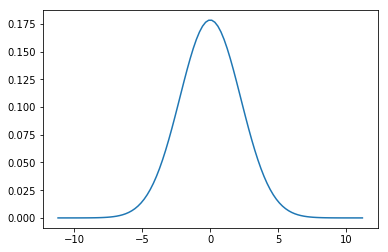

In [8]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
import scipy.stats

mu = 0
variance = 5
sigma = math.sqrt(variance)
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
plt.plot(x,scipy.stats.norm.pdf(x, mu, sigma))
plt.show()

多元高斯分布（以二维为例）：注意协方差矩阵的主对角线就是方差，非对角线上的就是两个变量间的协方差。就下面的二元高斯分布而言，协方差越大，图像越扁，也就是说两个维度之间越有联系。

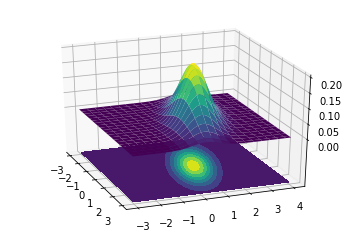

In [9]:
#Example from:
#https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 60
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 4, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 1.])
Sigma = np.array([[ 1.9 , -0.5], [-0.5,  0.5]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, -21)

plt.show()

### 贝叶斯滤波

首先，我们为什么要提到高斯分布等以上概率论内容：对于一个最基本的机器人定位问题来讲，如果机器人的运动模型是准确无误的，且机器人自身的里程计、imu等内部传感器是准确的、没有误差的，那么我们就已经能够准确定位机器人了——速度1m/s的机器人在1s后肯定会出现在1m距离以外；另一方面来说，如果机器人的GPS、激光雷达等传感器是准确的、没有误差的，那么我们也能通过机器人在地球坐标系中的位置或机器人在环境中的相对位置来准确定位机器人。

可惜的是，对于现实中的机器人来讲，我们很难得到准确的机器人运动模型，从机器人的里程计、imu、GPS、激光雷达等传感器中读到的信号也充满噪声，所以机器人的定位才不是一个简单的问题。

我们可以将机器人的状态（包括但不限于位置、角度、速度等）用多维随机变量来表示，一般取每一维变量的期望（也就是平均值）作为该时刻下该状态的估计值，用方差来表示该状态的噪声水平（模型误差、传感器噪声等）。

下面让我们跳过基于贝叶斯法则的一系列推导，直接快进到**贝叶斯滤波**：

The basic filter algorithm is:

for all $x_{t}$:

1. $\overline{bel}(x_t) = \int p(x_t | u_t, x_{t-1}) bel(x_{t-1})dx$

2. $bel(x_t) = \eta p(z_t | x_t) \overline{bel}(x_t)$

end.

其中$x_{t}$表示了某一时刻t下的机器人状态。

$\rightarrow$ 第一步被称为 **Prediction（预测）** 过程。 $p(x_t | u_t, x_{t-1})$ 可以理解为机器人的运动模型，表示的是机器人t时刻的状态的概率分布是如何受到t-1时刻的状态和t时刻的控制输入$u_{t}$影响的。比如，t-1时刻机器人在1.4m处，输入的$u_{t}$是1m/s，t和t-1时刻的时间间隔是1s，那么机器人在t时刻的位置就是2.4m处（不考虑误差的情况下）。所得到的$\overline{bel}(x_t)$状态预测值包含了运动模型误差、传感器误差等误差，因此“不确定性”有所增加。

$\rightarrow$ 第二步被称为 **Correction（更新update）** 过程。$p(z_t | x_t)$ 可以理解为机器人的观测模型，表示的是在t时刻下机器人处在$x_{t}$状态时能获得$z_{t}$测量值的概率。第二步更新过程是根据所获得的传感器$z_{t}$测量值对机器人状态进行修正的过程，得到$bel(x_t)$机器人在t时刻下的状态更新值，经过修正，“不确定性”减小。

### 卡尔曼滤波

如果以上贝叶斯滤波中的运动模型和观测模型都可以用线性系统表示，且各个噪声的分布都可以假设为高斯分布，那么这样的滤波就可以称作是一个卡尔曼滤波。

卡尔曼滤波器是在估计线性系统状态的过程中，以最小均方误差为目的而推导出的几个递推数学等式，也可以从贝叶斯推断的角度来推导。具体过程可以参考：[卡尔曼滤波 -- 从推导到应用(一)](https://blog.csdn.net/heyijia0327/article/details/17487467)，下面总结卡尔曼滤波的公式：

### Kalman Filter - 从一维到多维


<u>**Prediction预测**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
\text{一维高斯分布运算} & \text{一维卡尔曼} & \text{多维卡尔曼}\\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = x + dx & \bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = P + Q & \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$

$\mathbf x,\, \mathbf P$ 就是机器人状态向量的均值和其协方差矩阵（参见多维随机变量的均值和方差），对应一维高斯分布的均值 $x$ 和方差 $\sigma^2$.

$\mathbf F$ 就是 *状态转移方程*，在卡尔曼滤波中因为是线性系统，所以是与状态向量匹配的矩阵。如$\mathbf x$是系统的状态向量，大小为n×1列，则 $\mathbf F$大小为n×n。

$\mathbf Q$ 运动过程的协方差矩阵，包含了运动模型误差、各类负责监测运动过程的传感器（常见的有里程计、imu等）的误差等误差信息。对应一维的 $\sigma^2_{f_x}$.

$\mathbf B$ 和 $\mathbf u$ 是系统的模型控制输入。假如$\mathbf u$大小为k×1，$\mathbf B$是将输入转换为状态的矩阵，大小为n×k。注意这些矩阵的大小，它们将与实际编程密切相关。

<u>**Correction更新**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
\text{一维高斯分布运算} & \text{一维卡尔曼} & \text{多维卡尔曼}\\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & x = \bar x + Ky & \mathbf x = \bar{\mathbf x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & P = (1-K)\bar P &
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$

$\mathbf H$ 是观测方程，在卡尔曼滤波中，也是与状态向量匹配的矩阵。

$\mathbf z,\, \mathbf R$ 是测量值向量的均值与其协方差矩阵。对应一维高斯分布的 $z$ 和 $\sigma_z^2$。在多维的卡尔曼滤波中，$\mathbf z$是测量值，大小为m×1(注意不是n×1，也不是1×1），$\mathbf H$是状态变量到测量的转换矩阵，大小为m×n。

$\mathbf y$ 和 $\mathbf K$ 是残差和卡尔曼增益。

对于具体的卡尔曼滤波计算过程来讲，$\mathbf Q$ 运动过程的协方差矩阵、$\mathbf R$ 测量值的协方差矩阵是已知的，各个传感器的误差参数都可以填入这些矩阵。$\mathbf u$和$\mathbf z$是每一步的输入量，只要给出$\mathbf x,\, \mathbf P$ 机器人状态向量的均值和其协方差矩阵的初始值，就可以进行迭代计算了。

卡尔曼滤波器是高斯噪声下线性系统状态的最佳观测器，卡尔曼增益保证了状态向量均方误差最小。
